In [1]:
import numpy as np
import scipy.stats as stats             # For distribution functions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # For 3D graphs

plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure
# %matplotlib widget

## Merton Jump Diffusion Process

![MJD Process](merton_jump_diffusion.png)

In [2]:
N_SIMS = 20000                           # FIXME: number of simulations
N_STEPS = 200                            # FIXME: number of steps (excluding t = 0)
T = 1                                    # FIXME: time horizon
S0 = 100                                 # initial stock price (not using here for simplicity)

# GBM parameters
MU = 0.2                                 # FIXME: drift coefficient (GBM)
SIGMA = 0.3                              # FIXME: diffusion coefficient

MU = MU - 0.5 * SIGMA**2                 # fix drift coefficient for ABM

# Jump parameters (NCPP normal cumulative Possion process)
LAMBDA = 0.5                             # FIXME: jump rate
MU_J = -0.1                              # FIXME: jump mean
SIGMA_J = 0.15                           # FIXME: jump standard deviation

dt = T / N_STEPS
t_steps = np.linspace(0, T, N_STEPS + 1)

# Simulation =======================================================================
# NCPP -----------------------------------------------------------------------------
N = np.random.poisson(LAMBDA * dt, size = (N_STEPS, N_SIMS))
J = MU_J * N + SIGMA_J * np.sqrt(N) * np.random.randn(N_STEPS, N_SIMS)

# Compute ABM increments and add NCPP effects
S = MU * dt + SIGMA * np.sqrt(dt) * np.random.normal(size = (N_STEPS, N_SIMS))
S += J

# Combine to ABM
S = np.vstack([
    np.zeros(N_SIMS),
    S.cumsum(axis = 0)
])
S += S0

# Statistics =======================================================================
exact_mean = S0 + (MU + LAMBDA * MU_J) * t_steps
exact_var = (SIGMA**2 + LAMBDA * (MU_J**2 + SIGMA_J**2)) * t_steps
exact_skew = LAMBDA * MU_J * (MU_J**2 + 3 * SIGMA_J**2) / (np.power(SIGMA**2 + LAMBDA * (MU_J**2 + SIGMA_J**2), 3 / 2) * np.sqrt(t_steps))
exact_kurt = LAMBDA * (MU_J**4 + 6*MU_J**2 * SIGMA**2 + 3 * SIGMA_J**4) / ((SIGMA**2 + LAMBDA * (MU_J**2 + SIGMA_J**2))**2 * t_steps)

/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_39816/161810755.py:39: RuntimeWarning: divide by zero encountered in divide
  exact_skew = LAMBDA * MU_J * (MU_J**2 + 3 * SIGMA_J**2) / (np.power(SIGMA**2 + LAMBDA * (MU_J**2 + SIGMA_J**2), 3 / 2) * np.sqrt(t_steps))
/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_39816/161810755.py:40: RuntimeWarning: divide by zero encountered in divide
  exact_kurt = LAMBDA * (MU_J**4 + 6*MU_J**2 * SIGMA**2 + 3 * SIGMA_J**4) / ((SIGMA**2 + LAMBDA * (MU_J**2 + SIGMA_J**2))**2 * t_steps)


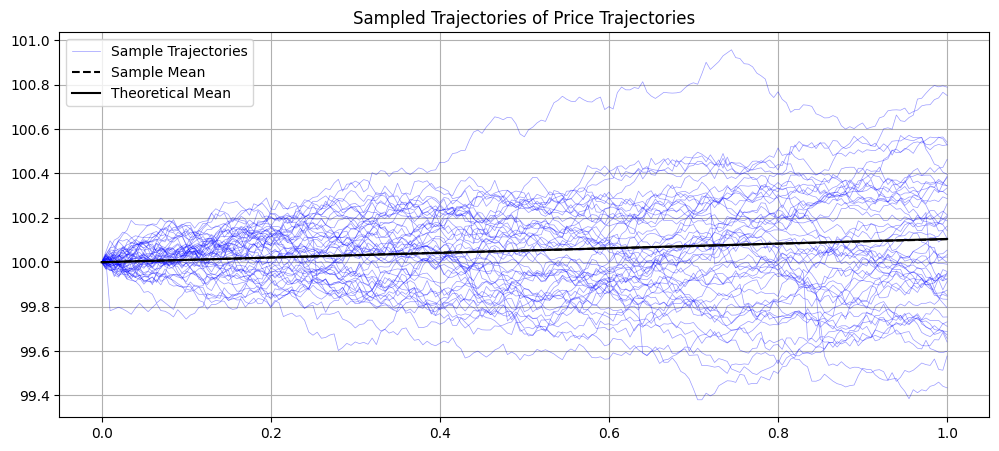

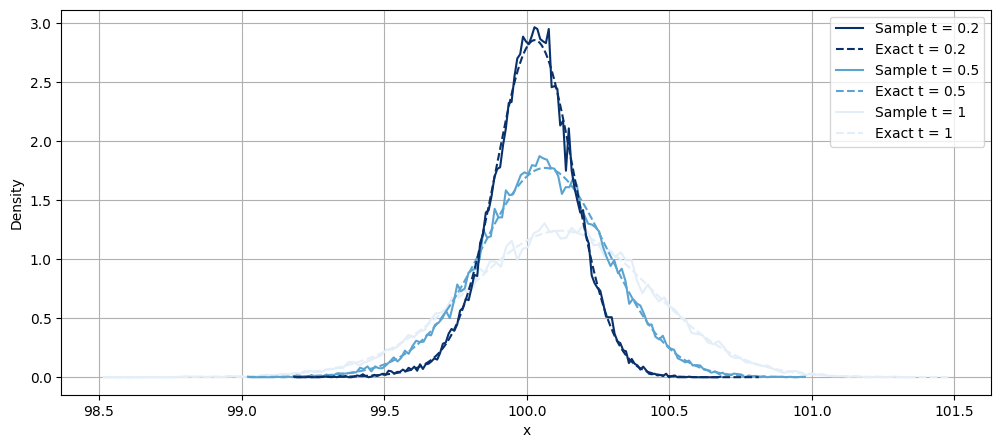

In [3]:
# Trajectories & Slices
# Price Trajectoris ==========================================================================
plt.figure(figsize = (12, 5), clear = True)

plt.title("Sampled Trajectories of Price Trajectories")
plt.plot(t_steps, S[:,:50], color = "blue", alpha = 0.4, lw = 0.5, label = "Sample Trajectories")
plt.plot(t_steps, S.mean(axis = 1), color = "black", linestyle = "--", label = "Sample Mean")
plt.plot(t_steps, exact_mean, color = "black", linestyle = "-", label = "Theoretical Mean")

handles, labels = plt.gca().get_legend_handles_labels() # This gets the handles and labels of the current axes
by_label = dict(zip(labels, handles)) # dict(zip(keys, values)) is a way to create a dictionary from two lists
plt.legend(by_label.values(), by_label.keys())
plt.grid()
plt.show()

# Slices =====================================================================================
SLICES = [0.2, 0.5, 1]       # FIXME: times to plot

colors = plt.cm.Blues(np.linspace(0.1, 1, len(SLICES))) # Inverse grey color direction

plt.figure(figsize = (12, 5), clear = True)

def mjd_charfunc(u, t, r, lam, mu, mu_j, sigma, sigma_j):
    return np.exp(1j * u * mu * t - 0.5 * u**2 * sigma**2 * t + lam * t * (np.exp(1j * u * mu_j - 0.5 * u**2 * sigma_j**2) - 1))

for i, time in enumerate(SLICES[::-1]): # Reverse slices so the nearest time is plotted at the front layer
    p, x = np.histogram(S[int(time * N_STEPS)], bins = 150, density = True)
    x = (x[:-1] + x[1:]) / 2 # Get the middle point of each bin

    # Recover exact pdf
    N = 1024
    x_centred = x - S0 # Shift to zero centre subtracting S0
    lower = -max(abs(x_centred.min()), abs(x_centred.max()))
    upper = -lower
    L = upper - lower
    dx = L / N
    xs = np.arange(lower, upper, dx) 
    dxi = 2 * np.pi / L
    xis = np.arange(-N/2, N/2) * dxi
    F = mjd_charfunc(xis, time, MU, LAMBDA, MU, MU_J, SIGMA, SIGMA_J)
    f = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(F))).real / L

    plt.plot(xs + S0, f, color = colors[i], linestyle = "--", label = f"Exact t = {time}")
    plt.plot(x, p, color = colors[i], linestyle = "-", label = f"Sample t = {time}")

# Reverse legend order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])

plt.xlabel("x")
plt.ylabel("Density")
plt.grid()
plt.show()

/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_39816/3669717987.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ax[1, 0].plot(t_steps, stats.skew(S, axis = 1), color = "red", label = "Sample Skewness")
/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_39816/3669717987.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ax[1, 1].plot(t_steps, stats.kurtosis(S, axis = 1), color = "red", label = "Sample Kurtosis")


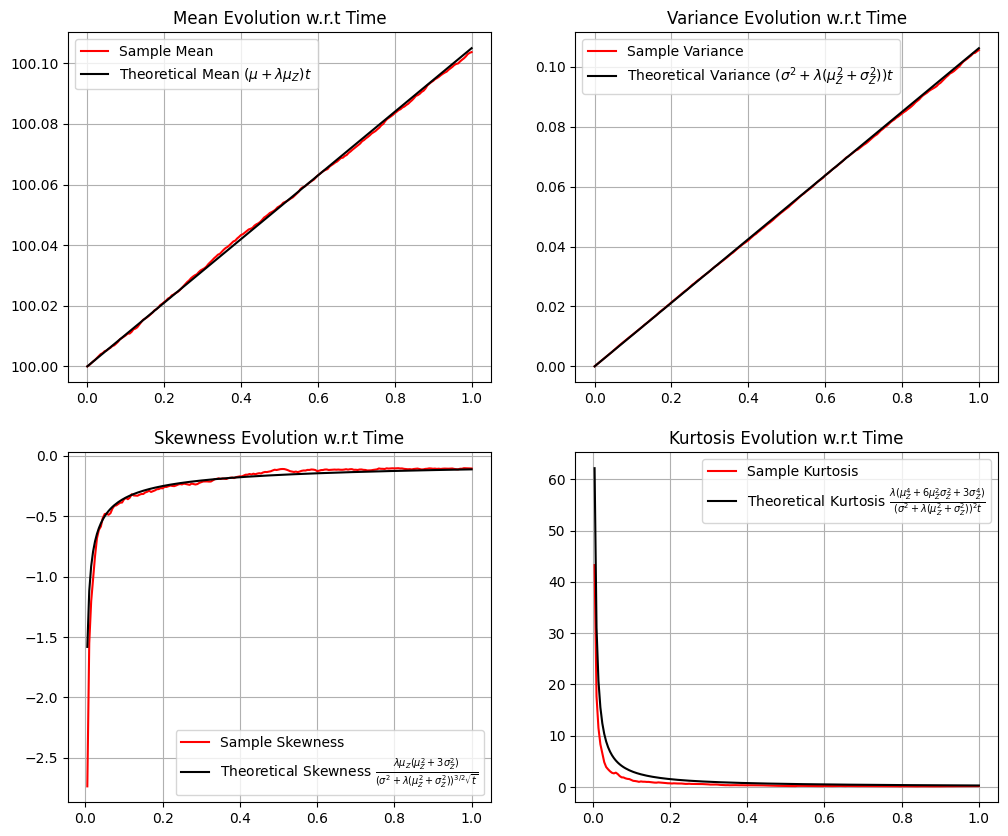

In [4]:
# Plotting Mean and Variance Convergence ==============================================
fig, ax = plt.subplots(2, 2, figsize = (12, 10), clear = True)

# Mean Convergence --------------------------------------------------------------------
ax[0, 0].set_title("Mean Evolution w.r.t Time")
ax[0, 0].plot(t_steps, S.mean(axis = 1), color = "red", label = "Sample Mean")
ax[0, 0].plot(t_steps, exact_mean, color = "black", label = r"Theoretical Mean $(\mu+\lambda\mu_Z)t$")

ax[0, 0].grid()
ax[0, 0].legend()

# Variance Convergence ----------------------------------------------------------------
ax[0, 1].set_title("Variance Evolution w.r.t Time")
ax[0, 1].plot(t_steps, S.var(axis = 1), color = "red", label = "Sample Variance")
ax[0, 1].plot(t_steps, exact_var, color = "black", label = r"Theoretical Variance $(\sigma^2 + \lambda(\mu_Z^2+\sigma_Z^2))t$")

ax[0, 1].grid()
ax[0, 1].legend()

# Skewness Convergence ----------------------------------------------------------------
ax[1, 0].set_title("Skewness Evolution w.r.t Time")
ax[1, 0].plot(t_steps, stats.skew(S, axis = 1), color = "red", label = "Sample Skewness")
ax[1, 0].plot(t_steps, exact_skew, color = "black", label = r"Theoretical Skewness $\frac{\lambda\mu_Z(\mu_Z^2+3\sigma_Z^2)}{(\sigma^2+\lambda(\mu_Z^2+\sigma_Z^2))^{3/2}\sqrt{t}}$")
ax[1, 0].grid()
ax[1, 0].legend()

# Kurtosis Convergence ----------------------------------------------------------------
ax[1, 1].set_title("Kurtosis Evolution w.r.t Time")
ax[1, 1].plot(t_steps, stats.kurtosis(S, axis = 1), color = "red", label = "Sample Kurtosis")
ax[1, 1].plot(t_steps, exact_kurt, color = "black", label = r"Theoretical Kurtosis $\frac{\lambda(\mu_Z^4+6\mu_Z^2\sigma_Z^2+3\sigma_Z^4)}{(\sigma^2+\lambda(\mu_Z^2+\sigma_Z^2))^2t}$")
ax[1, 1].grid()
ax[1, 1].legend()

plt.show()